# Recursive feature selection

In the present notebook, we will applied the recursive feature selection method with cross-validation using multiple classifiers (logistic regression, tree-based and ensemble) for for biomarker discovery (followed by gene enrichment analysis), and for dimensionality reduction to further implement ML models to differentiate between tumor and healthy breast tissue, based on microarray data available at the NIH - Gene Expression Omnibus (Superseries [GSE70951](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70951)).


## Data extraction and correction

The GSE70951 is composed of two series:

* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_1]*, with the code [GSE70905](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70905), which will be used as an external validation dataset
* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_2]*, with the code [GSE70947](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70947), which will be used for biomarker discovery

We will be using the second cohort for our analysis.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The data preprocessing and differential gene expression analysis was done in R using the `limma` package.

In [19]:
!gdown https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
!gdown https://drive.google.com/uc?id=1ViDbGJZU6RfwDPAfhnF7gjcFeQtyg_u2

Downloading...
From: https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
To: /content/GSE70947.csv
100% 176M/176M [00:00<00:00, 290MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ViDbGJZU6RfwDPAfhnF7gjcFeQtyg_u2
To: /content/GSE70947_DGE_filtered.csv
100% 296k/296k [00:00<00:00, 111MB/s]


The `GSE70947` file has the gene expression information. The columns are divided in
* `index`, which have the GEO code for each patient
* `type`, which has the class at which each patient belongs (either healthy or adenocarcinoma)
* the rest of the columns, that have the name of the gen an its expression level

In [20]:
gse = pd.read_csv('GSE70947.csv', index_col = 0)
gse.head()

,NM_144987,NM_013290,ENST00000322831,NM_001625,lincRNA:chr7:226042-232442_R,NM_032391,ENST00000238571,XR_108906,NM_005937,NM_152493,...,NM_152343,NM_001005327,NM_001039355,lincRNA:chr21:44456656-44468556_R,lincRNA:chr9:4869500-4896050_F,NM_016053,NM_001080425,ENST00000555638,ENST00000508993,type
GSM1823702,8.710837,7.752260,6.147044,11.330250,8.049364,4.786607,5.762913,4.673030,8.595702,10.700061,...,6.452793,4.861030,10.751960,5.231761,6.099910,10.653872,8.983922,5.117210,5.231761,healthy
GSM1823703,9.386920,7.125349,7.033364,11.043588,8.546755,5.365691,5.564553,4.966745,8.505314,10.952910,...,5.836469,3.858494,11.302093,4.003188,3.858494,10.751094,8.199526,4.085583,4.355808,healthy
GSM1823704,8.958187,7.993491,6.358601,11.548966,8.616110,5.402829,5.941259,5.093209,8.683907,10.574121,...,6.668138,3.793648,10.581576,5.137291,6.605187,10.435313,8.493851,4.669778,5.225001,healthy
GSM1823705,9.034777,7.856471,6.260612,12.290221,7.724913,4.631357,6.745727,4.840550,8.573251,10.787665,...,5.905563,4.458250,11.178242,5.123130,6.739206,11.113692,8.896214,4.358008,4.631357,healthy
GSM1823706,8.822363,7.593622,6.322608,12.204265,7.785088,4.295037,6.597042,4.366717,8.788972,10.818610,...,5.672441,4.557420,12.016128,5.110453,6.496323,10.913592,9.536360,4.673507,4.557420,healthy


The `DGE` file contains the results of the differential gene expression, considering a $\log |\text{FC}| > 1$ and $\text{adj.P-val} < 0.05$ as thresholds

In [21]:
dge = pd.read_csv('GSE70947_DGE_filtered.csv', index_col = 0)
dge.head()

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,diffexpressed
lincRNA:chr2:216585154-216585719_F,lincRNA:chr2:216585154-216585719_F,3.725171,7.142946,16.750688,1.316560e-44,3.454359e-40,90.700821,UP
NM_006086,NM_006086,3.048427,7.739344,16.663225,2.786762e-44,3.454359e-40,89.958877,UP
NM_004456,NM_004456,1.699635,7.972860,16.625759,3.842303e-44,3.454359e-40,89.641072,UP
NM_002141,NM_002141,-1.344960,7.782020,-16.404438,2.561246e-43,1.726984e-39,87.764022,DOWN
lincRNA:chr4:89637527-89646627_R,lincRNA:chr4:89637527-89646627_R,-1.904182,7.375651,-16.067836,4.577865e-42,2.469392e-38,84.910909,DOWN


Extracting the target,

In [22]:
from sklearn.preprocessing import LabelEncoder
y = gse["type"]
y = LabelEncoder().fit_transform(y)

and storing the data in the variable `X`.

In [23]:
X = gse.drop(["type"], axis = 1)
X = X[np.array(dge["ID"])]
X.head()

,lincRNA:chr2:216585154-216585719_F,NM_006086,NM_004456,NM_002141,lincRNA:chr4:89637527-89646627_R,NM_014736,NM_005480,NM_016359,NM_004336,NM_001083961,...,NM_001178126,NP113779,S77011,ENST00000498435,NM_002411,A_33_P3251412,NM_012188,NM_006552,NM_006551,NM_002652
GSM1823702,4.786607,6.321416,6.808873,8.685651,9.205305,5.675846,6.558804,6.124203,4.509872,7.197222,...,13.480088,9.728459,12.696556,9.518063,7.363144,9.754804,5.468174,7.310242,7.644311,8.949257
GSM1823703,7.644079,9.365653,7.938209,7.063652,7.311140,7.116449,7.892767,7.016965,4.633230,8.543367,...,13.369119,10.337995,12.618046,10.213340,12.581711,8.704484,6.232431,11.249700,11.713772,13.530426
GSM1823704,4.687383,4.830394,6.870517,8.485212,10.360521,5.066081,6.646007,4.805947,3.501254,7.634662,...,10.077759,6.817671,9.302829,6.409630,3.621975,6.006907,1.449203,4.598337,4.635677,4.456936
GSM1823705,5.097593,5.676941,7.078230,8.328697,9.077607,5.916410,6.553197,5.758328,4.256620,7.382161,...,13.854754,11.696181,12.933871,10.968928,11.478130,9.929380,8.450231,11.012945,11.134689,12.588631
GSM1823706,5.012687,5.626693,7.558369,8.562031,9.844757,6.741824,6.729353,6.239319,5.328063,7.545784,...,17.035073,14.224910,16.074557,13.696180,16.456441,13.741491,7.200912,15.944112,15.928179,17.924073


## RFECV feature selection

The final subset of genes considered biomarkers will be obtained from the result of the RFECV with a Logistic Regression model.

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

min_features_to_select = 2
cv = StratifiedKFold(5)

rfe = RFECV(
      estimator=LogisticRegression(),
      step=1,
      cv=cv,
      scoring="accuracy",
      min_features_to_select=min_features_to_select,
      n_jobs=-1,)

rfe.fit(X, y)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(), min_features_to_select=2, n_jobs=-1,
      scoring='accuracy')

We can observe the mean accuracy of each rfecv operation in the following plot.

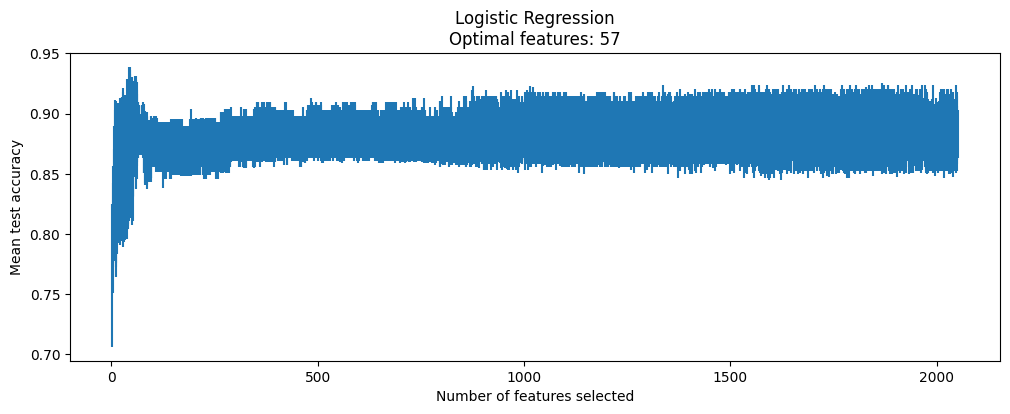

In [25]:
#@title Optimal feature
plt.figure(figsize = (12,4))
model = 'Logistic Regression' #@param ["Random Forest", "Logistic Regression", "XGBoost", "AdaBoost", "Decision Tree"]

n_scores = len(rfe.cv_results_["mean_test_score"])
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfe.cv_results_["mean_test_score"],
    yerr=rfe.cv_results_["std_test_score"],
)
plt.title(model + '\nOptimal features: ' + str(rfe.n_features_))
plt.show()

### Important genes across different models

Extracting the most important genes for each model, which will be the ones that have a ranking = 1.

In [26]:
ranking = np.array([])
gene_names = np.array([])
ranking = np.append(ranking, rfe.ranking_)
gene_names = np.append(gene_names, rfe.feature_names_in_)

Then, from the most important genes, we will search for the ones that are repeated the most across the different rfecv implementations.

In [27]:
genes = pd.DataFrame({'Gen ID': gene_names, 'Ranking': ranking})
genes = genes[genes['Ranking'] == 1]
values, counts = np.unique(genes['Gen ID'], return_counts=True)
most_important = pd.DataFrame({'Unique genes': values, 'Repetitions': counts})
most_important = most_important.sort_values(by = ['Repetitions'], ascending = False)
most_important = most_important.reset_index(drop = True)

Analyzing the expression of each gene.

In [28]:
# plt.figure(figsize = (8,8))
# biomarkers = most_important['Unique genes']

# for n, bio in enumerate(biomarkers):
#   ax = plt.subplot(3,3, n+1)

#   sns.boxplot(x = 'type', y = bio, data = gse, ax = ax)
#   ax.set_xticklabels(['healthy', 'adenocarcinoma'])

#   plt.title(bio)

# plt.tight_layout()
# plt.show()

## Machine learning models

In [29]:
X = X[most_important['Unique genes']]
X.head()

,AK075287,NM_014988,NM_021189,NM_021935,NM_022003,NM_022082,NM_022145,NM_024861,NM_032405,NM_032784,...,NM_002427,NM_002445,NM_002692,NM_003535,NM_003537,NM_003568,NM_005623,NM_005924,NM_006274,lincRNA:chr8:38627589-38630415_F
GSM1823702,5.793464,11.167415,9.076651,8.368829,10.563939,7.586502,4.548700,3.085188,5.144669,8.848787,...,4.342273,7.092858,5.729466,6.590621,7.216630,5.803404,10.321980,9.351871,9.580165,11.003363
GSM1823703,5.424440,9.148302,8.708997,4.871699,10.631370,10.135810,3.765804,3.360379,5.821599,7.355231,...,4.617211,11.607309,4.321146,6.507991,8.533953,6.202852,9.024274,8.037945,9.546531,8.571953
GSM1823704,5.856692,11.675004,8.178388,5.681998,9.979514,6.536728,3.609522,2.492924,4.787214,9.150488,...,4.059358,8.101295,5.130610,6.709126,7.701302,4.810868,9.784833,9.756949,10.104700,10.631574
GSM1823705,5.554191,11.610615,7.765141,5.133251,10.489624,6.993767,4.869642,3.287472,5.133251,9.450791,...,4.686886,6.200136,5.969220,6.470118,7.096083,5.263036,8.325039,9.677129,9.147400,11.970984
GSM1823706,5.682298,11.314138,8.613667,4.891449,10.082449,7.879612,4.725558,5.311615,5.538727,9.632457,...,4.129133,5.997617,6.333485,6.481427,7.589480,6.854594,8.111279,9.100029,10.087019,11.223991


In [30]:
# Exporting the identified genes
with open('rfecv_genes.txt', 'w') as my_file:
      for genei in list(X.columns):
          my_file.write(genei + '\n')

In [31]:
# df_aux = X.loc[:]
# df_aux['type'] = gse['type']
# sns.pairplot(df_aux, hue = "type")

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42,
                                                    stratify = y)

In [33]:
#@title Classifiers´ implementation

clf = []

# Utilizaremos GridSearch para obtener los mejores parámetros para cada clasificador
from sklearn.model_selection import GridSearchCV

# Dummy classifier for baseline
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
clf.append(dummy_clf)

# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
clf.append(lr_clf)

# Support Vector Machine
from sklearn.svm import SVC

param_grid = {'kernel': ['linear', 'poly', 'rbf'],
              'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.001, 0.0001]}

svm_clf = SVC()
svm_GS = GridSearchCV(svm_clf, param_grid)
clf.append(svm_GS)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [10,50,100,200, 1000],
              'min_weight_fraction_leaf': [0.0, 0.5],
              'max_features': ['sqrt', 'log2']
              }

rf_clf = RandomForestClassifier()
rf_GS = GridSearchCV(rf_clf, param_grid)
clf.append(rf_GS)

# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(5,21),
              }

knn_clf = KNeighborsClassifier()
knn_GS = GridSearchCV(knn_clf, param_grid)
clf.append(knn_GS)

from xgboost import XGBClassifier

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.01, 0.03, 0.06, 0.1],
              'max_depth': [5,6,7,8],
              'n_estimators': [50,65,80,100,115,130,150],
              }

xgb_clf = XGBClassifier(objective="binary:logistic")
xgb_GS = GridSearchCV(xgb_clf, param_grid)
clf.append(xgb_GS)

# Fit
for model in clf:
  model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
#@title Performance metrics
y_pred = [model.predict(X_test) for model in clf]
labels = ["Dummy Classifier", "Logistic regression", "SVM", "Random Forest", "KNN", "XGBoost"]
metrics = {'Accuracy':list(), 'F1 score':list(), 'Precision':list(), 'Recall':list(), 'AUC': list()}

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

for j in range(len(y_pred)):
  metrics['Accuracy'].append(accuracy_score(y_test, y_pred[j]))
  metrics['F1 score'].append(f1_score(y_test, y_pred[j],))
  metrics['Precision'].append(precision_score(y_test, y_pred[j],))
  metrics['Recall'].append(recall_score(y_test, y_pred[j],))
  metrics['AUC'].append(roc_auc_score(y_test, y_pred[j],))

df_metrics = pd.DataFrame(metrics)
df_metrics.insert(0, 'Clasificadores', labels)
df_metrics.set_index('Clasificadores', inplace=True)
print(df_metrics)

                     Accuracy  F1 score  Precision    Recall       AUC
Clasificadores                                                        
Dummy Classifier     0.500000  0.000000   0.000000  0.000000  0.500000
Logistic regression  0.947917  0.947368   0.957447  0.937500  0.947917
SVM                  0.979167  0.979167   0.979167  0.979167  0.979167
Random Forest        0.864583  0.863158   0.872340  0.854167  0.864583
KNN                  0.854167  0.865385   0.803571  0.937500  0.854167
XGBoost              0.906250  0.909091   0.882353  0.937500  0.906250


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


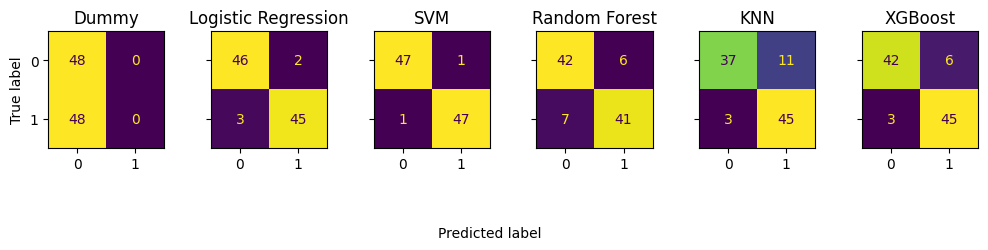

In [35]:
#@title Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['Dummy', 'Logistic Regression', 'SVM', 'Random Forest', 'KNN', 'XGBoost']

f, axes = plt.subplots(1, 6, figsize=(12, 5), sharey='row')

for i in range(6):
    cf_matrix = confusion_matrix(y_test, y_pred[i])
    disp = ConfusionMatrixDisplay(cf_matrix,)
    disp.plot(ax=axes[i],)
    disp.ax_.set_title(labels[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.2, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()